In [7]:
# import all libraries
import torch
import torch.nn as nn
from torch.utils.data import random_split
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

import os
import argparse


In [8]:
import pickle

# Define transforms (keep these - they're still needed!)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the saved datasets from pickle files
print("Loading datasets from pickle files...")

with open('./data/train_dataset.pkl', 'rb') as f:
    trainset = pickle.load(f)

with open('./data/val_dataset.pkl', 'rb') as f:
    valset = pickle.load(f)

# Don't load test for Section 4 (not needed)
# with open('./data/test_dataset.pkl', 'rb') as f:
#     testset = pickle.load(f)

print(f"✅ Loaded! Train={len(trainset)}, Val={len(valset)}")

# Create DataLoaders
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(
    valset, batch_size=128, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Loading datasets from pickle files...
✅ Loaded! Train=40000, Val=10000


In [9]:
# Get the size of the dataset
print(f"Training set size: {len(trainset)}")
print(f"Val set size: {len(valset)}")  # if you have testset defined

Training set size: 40000
Val set size: 10000




---



In [10]:
# Training
def train(epoch, net, criterion, trainloader, scheduler=None):
    device = 'cuda'
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx+1) % 50 == 0:
          print("iteration : %3d, loss : %0.4f, accuracy : %2.2f" % (batch_idx+1, train_loss/(batch_idx+1), 100.*correct/total))

    if scheduler is not None:
        scheduler.step()
    return train_loss/(batch_idx+1), 100.*correct/total

Test performance on the test set. Note the use of `torch.inference_mode()`

In [11]:
def test(epoch, net, criterion, testloader):
    device = 'cuda'
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.inference_mode():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/(batch_idx+1), 100.*correct/total



In [12]:
def save_checkpoint(net, acc, epoch):
    # Save checkpoint.
    print('Saving..')
    state = {
        'net': net.state_dict(),
        'acc': acc,
        'epoch': epoch,
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.pth')





In [13]:
# defining resnet models

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # This is the "stem"
        # For CIFAR (32x32 images), it does not perform downsampling
        # It should downsample for ImageNet
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # four stages with three downsampling
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test_resnet18():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())


## Learning Rate
Values = 0.1, 0.01, 0.001

BS = 128

Data Aug = random cropping and random horizontal flip (as per NTULearn code)

Epochs = 15

No weight decay or learning rate schedule


Training with Learning Rate: 0.1


Epoch: 1
iteration :  50, loss : 3.0912, accuracy : 15.89
iteration : 100, loss : 2.5549, accuracy : 19.67
iteration : 150, loss : 2.3394, accuracy : 22.32
iteration : 200, loss : 2.2183, accuracy : 24.16
iteration : 250, loss : 2.1356, accuracy : 25.48
iteration : 300, loss : 2.0675, accuracy : 27.04
Epoch :   1, training loss : 2.0518, training accuracy : 27.50, val loss : 1.7174, val accuracy : 36.13

Epoch: 2
iteration :  50, loss : 1.6784, accuracy : 36.81
iteration : 100, loss : 1.6472, accuracy : 38.20
iteration : 150, loss : 1.6264, accuracy : 39.12
iteration : 200, loss : 1.6070, accuracy : 40.11
iteration : 250, loss : 1.5895, accuracy : 40.82
iteration : 300, loss : 1.5705, accuracy : 41.58
Epoch :   2, training loss : 1.5678, training accuracy : 41.68, val loss : 1.4659, val accuracy : 45.21

Epoch: 3
iteration :  50, loss : 1.4398, accuracy : 47.12
iteration : 100, loss : 1.4253, accuracy : 47.73
iteration : 150, loss : 1.4158, accuracy 

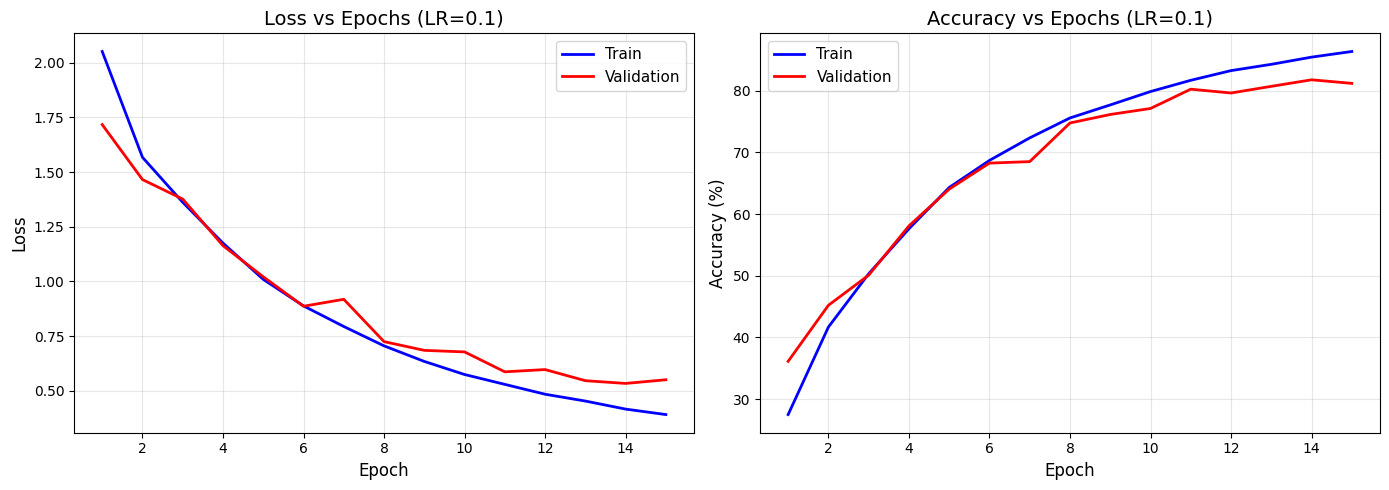


Final Results for LR=0.1:
  Train Loss: 0.3908, Train Acc: 86.34%
  Val Loss: 0.5501, Val Acc: 81.17%


Training with Learning Rate: 0.01


Epoch: 1
iteration :  50, loss : 1.9901, accuracy : 26.52
iteration : 100, loss : 1.8399, accuracy : 32.29
iteration : 150, loss : 1.7277, accuracy : 36.71
iteration : 200, loss : 1.6316, accuracy : 40.32
iteration : 250, loss : 1.5624, accuracy : 42.97
iteration : 300, loss : 1.5133, accuracy : 44.83
Epoch :   1, training loss : 1.4985, training accuracy : 45.46, val loss : 1.2377, val accuracy : 55.81

Epoch: 2
iteration :  50, loss : 1.1058, accuracy : 60.38
iteration : 100, loss : 1.1088, accuracy : 60.01
iteration : 150, loss : 1.0930, accuracy : 60.64
iteration : 200, loss : 1.0691, accuracy : 61.60
iteration : 250, loss : 1.0422, accuracy : 62.65
iteration : 300, loss : 1.0220, accuracy : 63.49
Epoch :   2, training loss : 1.0149, training accuracy : 63.74, val loss : 1.1074, val accuracy : 62.40

Epoch: 3
iteration :  50, loss : 0.8299, ac

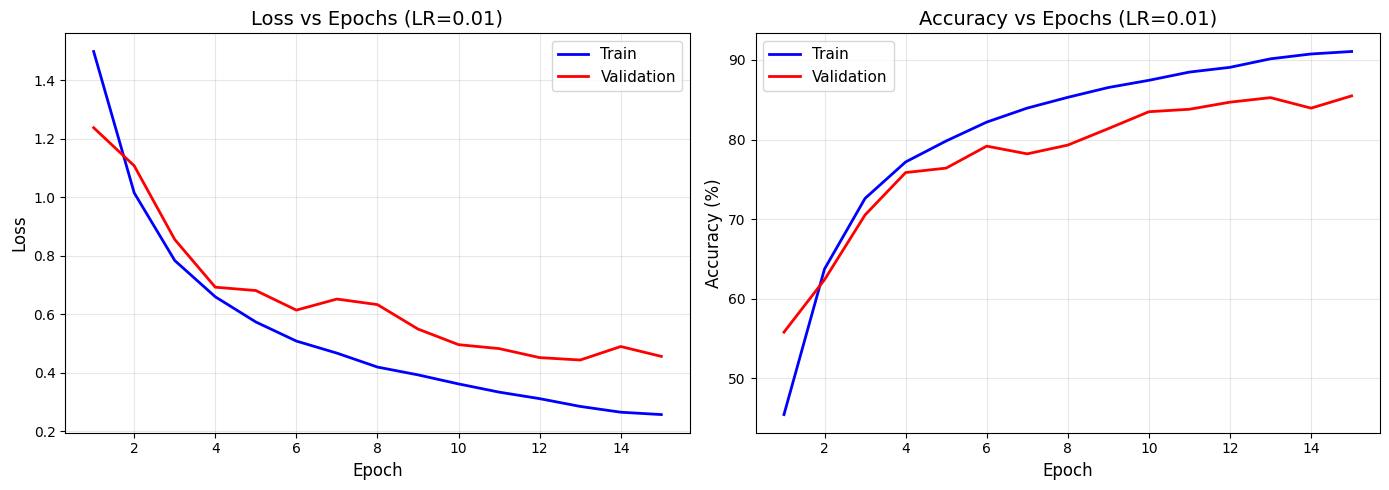


Final Results for LR=0.01:
  Train Loss: 0.2564, Train Acc: 91.06%
  Val Loss: 0.4554, Val Acc: 85.48%


Training with Learning Rate: 0.001


Epoch: 1
iteration :  50, loss : 2.0968, accuracy : 21.61
iteration : 100, loss : 1.9585, accuracy : 27.45
iteration : 150, loss : 1.8623, accuracy : 30.86
iteration : 200, loss : 1.7933, accuracy : 33.30
iteration : 250, loss : 1.7351, accuracy : 35.49
iteration : 300, loss : 1.6908, accuracy : 37.27
Epoch :   1, training loss : 1.6792, training accuracy : 37.66, val loss : 1.4584, val accuracy : 47.16

Epoch: 2
iteration :  50, loss : 1.3546, accuracy : 50.56
iteration : 100, loss : 1.3423, accuracy : 51.12
iteration : 150, loss : 1.3216, accuracy : 51.77
iteration : 200, loss : 1.3045, accuracy : 52.51
iteration : 250, loss : 1.2876, accuracy : 53.13
iteration : 300, loss : 1.2692, accuracy : 53.83
Epoch :   2, training loss : 1.2665, training accuracy : 53.92, val loss : 1.2088, val accuracy : 56.43

Epoch: 3
iteration :  50, loss : 1.1219, 

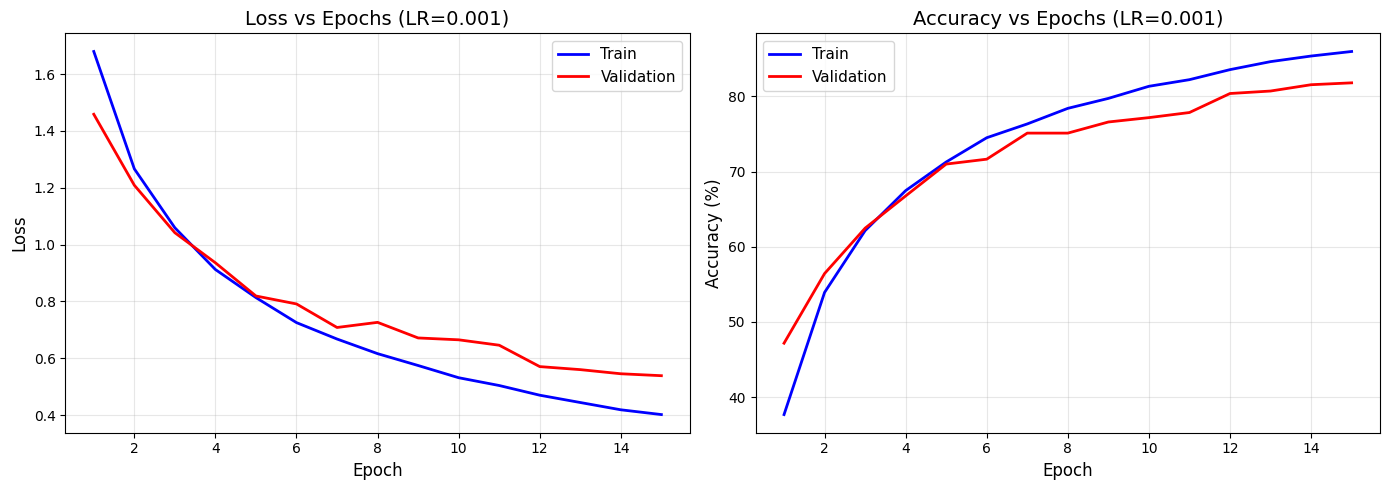


Final Results for LR=0.001:
  Train Loss: 0.4023, Train Acc: 85.98%
  Val Loss: 0.5390, Val Acc: 81.81%



In [ ]:

learning_rates = [0.1, 0.01, 0.001]

all_results = {}

for learning_rate in learning_rates:
    print(f"\n{'='*60}")
    print(f"Training with Learning Rate: {learning_rate}")
    print(f"{'='*60}\n")

    # Initialize model and optimizer
    net = ResNet18().to('cuda')
    criterion = nn.CrossEntropyLoss().to('cuda')
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    # Lists to store losses and accuracies
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    # Training loop
    for epoch in range(1, 16): #1-15
        train_loss, train_acc = train(epoch, net, criterion, trainloader)
        val_loss, val_acc = test(epoch, net, criterion, valloader)

        # Store values
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, val loss " + \
              ": %0.4f, val accuracy : %2.2f") % (epoch, train_loss, train_acc, val_loss, val_acc))

    # Store results for comparison
    all_results[learning_rate] = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs
    }

    # Plot for this learning rate
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    ax1.plot(range(1, 16), train_losses, 'b-', label='Train', linewidth=2)
    ax1.plot(range(1, 16), val_losses, 'r-', label='Validation', linewidth=2)
    ax1.set_xlabel("Epoch", fontsize=12)
    ax1.set_ylabel("Loss", fontsize=12)
    ax1.set_title(f"Loss vs Epochs (LR={learning_rate})", fontsize=14)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(range(1, 16), train_accs, 'b-', label='Train', linewidth=2)
    ax2.plot(range(1, 16), val_accs, 'r-', label='Validation', linewidth=2)
    ax2.set_xlabel("Epoch", fontsize=12)
    ax2.set_ylabel("Accuracy (%)", fontsize=12)
    ax2.set_title(f"Accuracy vs Epochs (LR={learning_rate})", fontsize=14)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'section3_lr_{learning_rate}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print final results
    print(f"\n{'='*60}")
    print(f"Final Results for LR={learning_rate}:")
    print(f"  Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.2f}%")
    print(f"  Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.2f}%")
    print(f"{'='*60}\n")